# Financial Fraud Detection

### Dataset Knowledge
The dataset is financial transaction data presumiably from a type of bank. This dataset has already been encoded to show which rows are fraudulent data. Our goal is to create a supervised model that can accurately identify fraudulent transcactions with new data while limiting the number of false positives.

### Features
● Step: A unit of time that represents hours in the dataset. 

● Type: The type of transaction 

● Amount: The amount of money transferred 

● NameOrig: The origin account name

● OldBalanceOrg: The origin accounts balance before the transaction 

● NewBalanceOrg: The origin accounts balance after the transaction 

● NameDest: The destination account name 

● OldbalanceDest: The destination accounts balance before the transaction 

● NewbalanceDest: The destination accounts balance after the transaction 

● IsFraud: Was this simulated transaction actually fraudulent? In this case, we consider “fraud” to be a malicious transaction that aimed to transfer funds out of a victim’s bank account before the account owner could secure their information. 

● IsFlaggedFraud: A “naive” model that simply flags a transaction as fraudulent if it is greater than 200,000. This column does not seem to have any benefit and will be removed in the cleaning process.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder

In [3]:
financials = pd.read_csv("/Users/sa12/Documents/Repositories/FinancialFraudDetection/FraudData/financials.csv", index_col=0)

In [4]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6362620 entries, 1 to 743
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 534.0+ MB


These are some ugly column names. gonna change them to something simpiler and maintain specifictiy.

In [5]:
financials.rename(columns={'amount':'Amount','oldbalanceOrg':'OldOrig','newbalanceOrig':'NewOrig','oldbalanceDest':'OldDest','newbalanceDest':'NewDest'}, inplace=True)
financials.head()

,type,Amount,nameOrig,OldOrig,NewOrig,nameDest,OldDest,NewDest,isFraud,isFlaggedFraud
step,,,,,,,,,,
1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


The nameOrig and nameDest column identify the individual accounts involved. While it might be useful to police to identify who is commiting fraud, it is not valuable to our model to predict if fraud is occuring. We can drop these columns in the cleaning process.

In [6]:
financials.describe()

,Amount,OldOrig,NewOrig,OldDest,NewDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The range between the min value and the max value across all numerical columns is very wide. These columns will need to be normalized before doing any bivariate analysis.

### Univariate Analysis

My first steps will be to identify the number of transaction that fall into the fraud catagory, than analyze the other catagorical column, type.

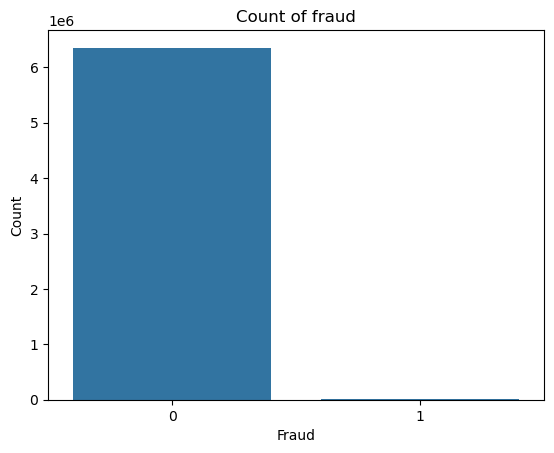

In [7]:
sns.countplot(data=financials, x='isFraud')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Count of fraud')
plt.show()

Fraud cases are very much in the minority. I will need to isolate the fraud data in order to find any type of pattern in the noise.

In [43]:
#create seperate dataframe with Fraud and Not Fraud exclusively
fraud = financials[financials['isFraud'] == 1]
not_fraud = financials[financials['isFraud'] == 0]
fraud.describe()

,Amount,OldOrig,NewOrig,OldDest,NewDest,isFraud,isFlaggedFraud
count,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8213.0,8213.000000
mean,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06,1.0,0.001948
std,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06,0.0,0.044097
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000
25%,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000
50%,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03,1.0,0.000000
75%,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06,1.0,0.000000
max,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.0,1.000000


In [44]:
not_fraud.describe()

,Amount,OldOrig,NewOrig,OldDest,NewDest,isFraud,isFlaggedFraud
count,6.354407e+06,6.354407e+06,6.354407e+06,6.354407e+06,6.354407e+06,6354407.0,6354407.0
mean,1.781970e+05,8.328287e+05,8.559702e+05,1.101421e+06,1.224926e+06,0.0,0.0
std,5.962370e+05,2.887144e+06,2.924987e+06,3.399202e+06,3.673816e+06,0.0,0.0
min,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,1.336840e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
50%,7.468472e+04,1.406900e+04,0.000000e+00,1.333118e+05,2.148817e+05,0.0,0.0
75%,2.083648e+05,1.069695e+05,1.447307e+05,9.441446e+05,1.111975e+06,0.0,0.0
max,9.244552e+07,4.381886e+07,4.368662e+07,3.560159e+08,3.561793e+08,0.0,0.0


Looking at this summary data of the data sets, a few points stand out:
First the average value of the old original account is 

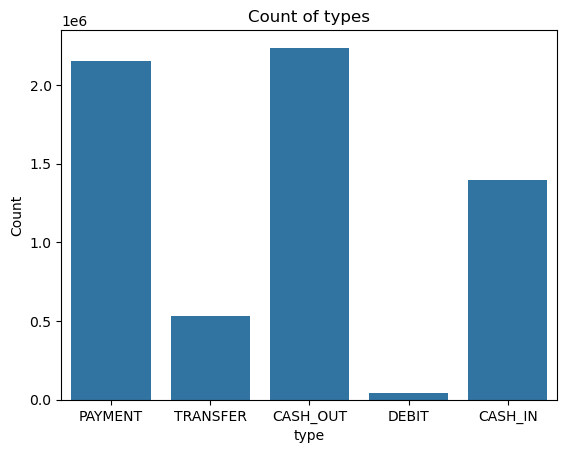

In [9]:
sns.countplot(data=financials, x='type')
plt.xlabel('type')
plt.ylabel('Count')
plt.title('Count of types')
plt.show()

The ditribution across types doesn't give us any vauable info. However, given the tiny number of fraud cases in our data we may be able to eliminate some data if we find fraud doesnt exist in that type of transaction.

Let's visualize our unnormalized distributions across our numerical columns.

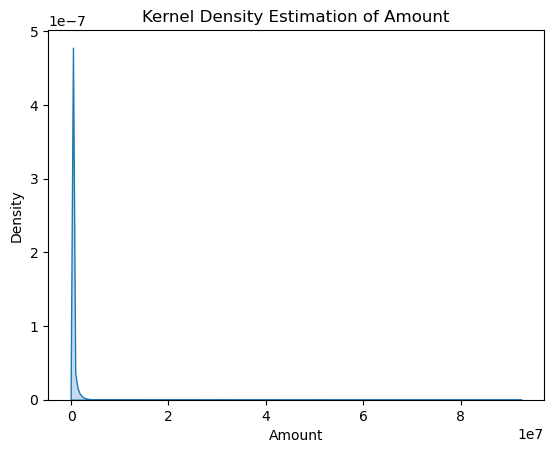

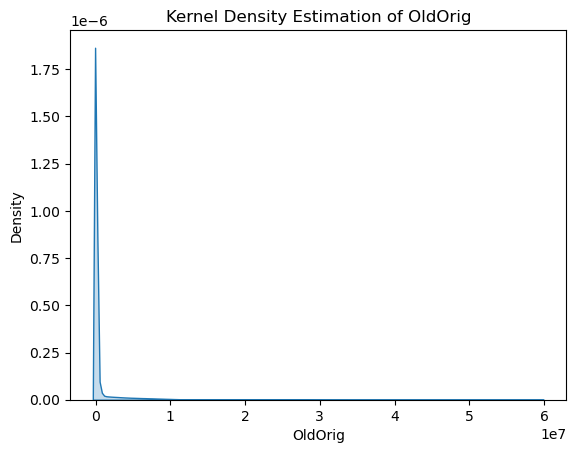

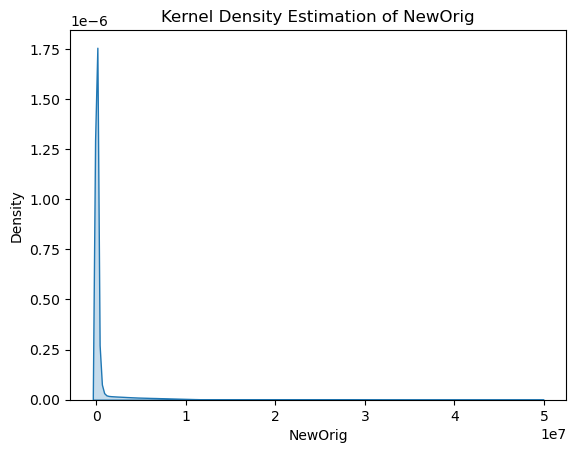

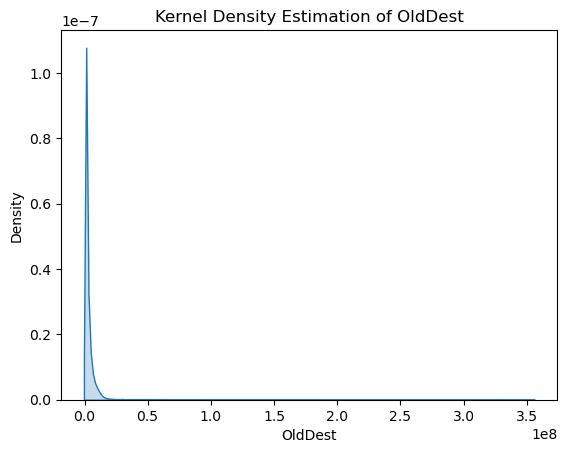

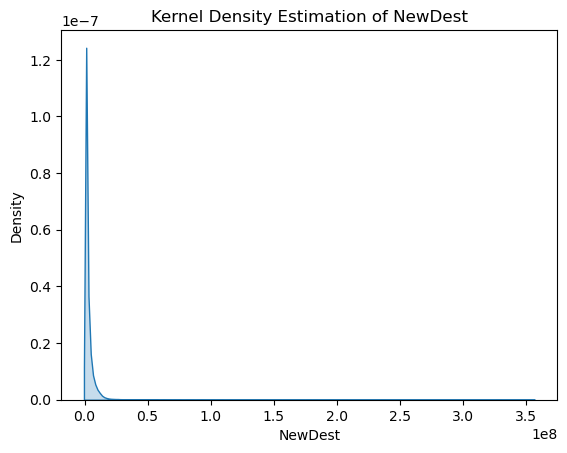

In [10]:
#remove non numeric columns for comparisons
num_financials = financials.drop(columns=['nameOrig', 'nameDest', 'isFraud','isFlaggedFraud','type'])
# Iterate over each feature column and plot kde plot
for feature in num_financials.columns:
    sns.kdeplot(data=num_financials, x=feature, fill=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Kernel Density Estimation of {feature}')
    plt.show()

All of the data is heavily skewed to the right. I am going to produce a similar chart, only looking at fraudulent transactions.

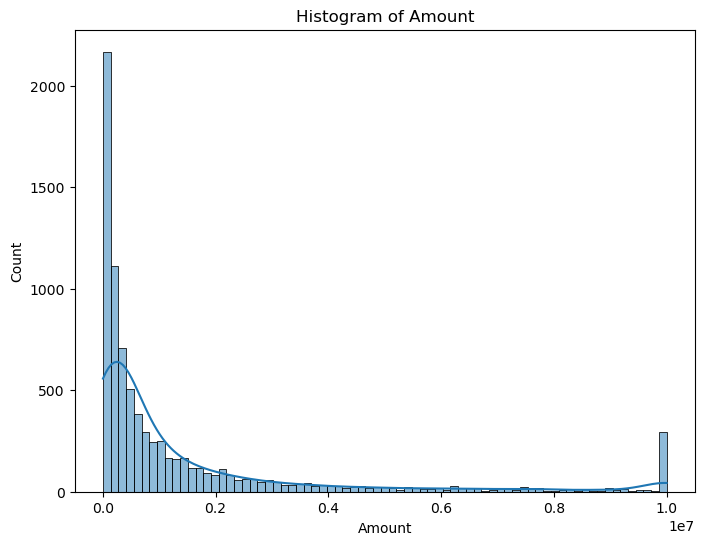

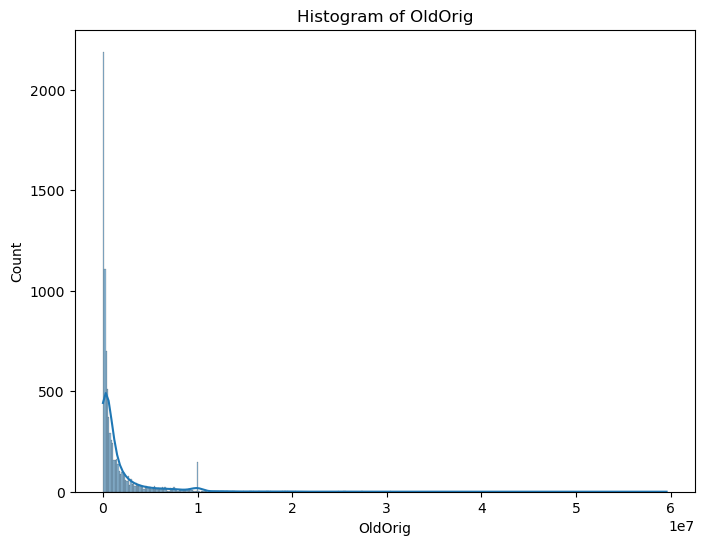

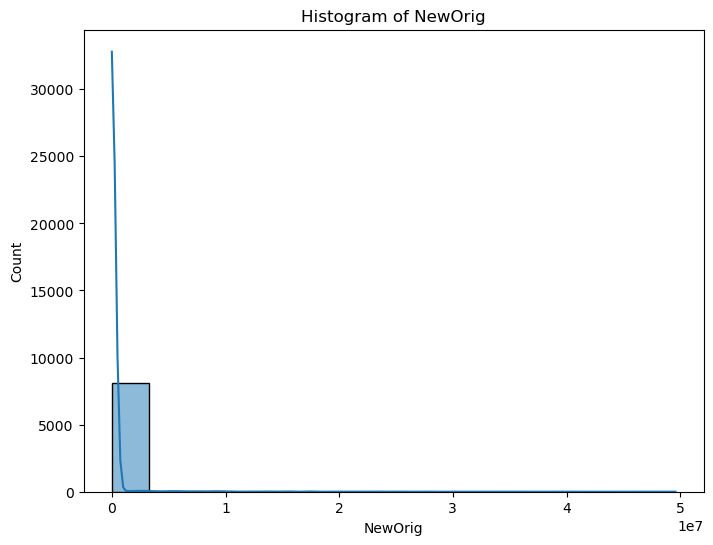

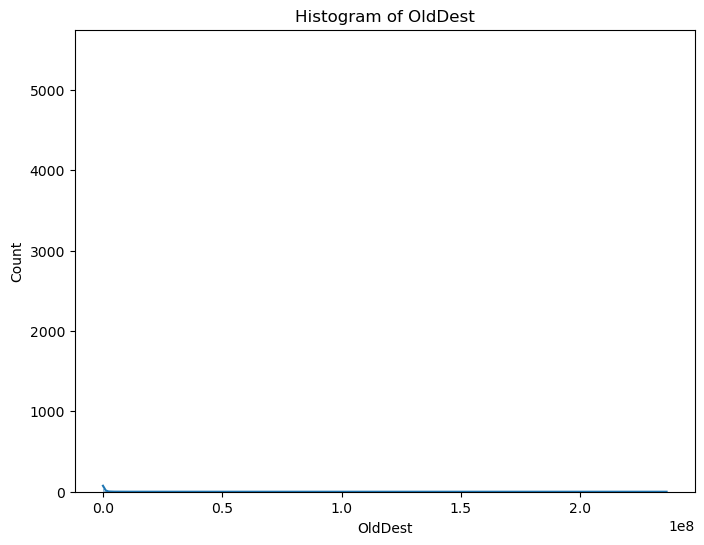

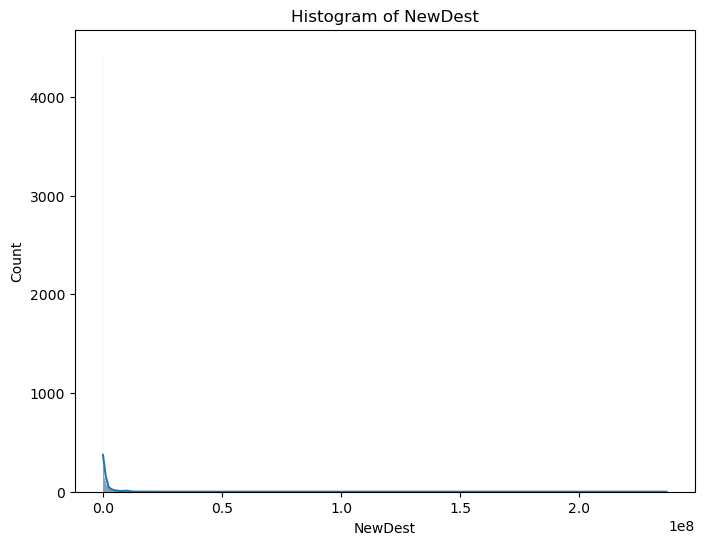

In [11]:
plot_fraud = fraud.drop(columns=['nameOrig', 'nameDest', 'isFraud','isFlaggedFraud','type'])
for feature in plot_fraud:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=fraud, x=feature, kde=True)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Histogram of {feature}')
    plt.show()

There is also a heavy right skew here, too. We also can see a large bump in the amount column on the far right. This indicates a large amount of values concentrated in large amounts when looking specifically at fraud.

## Bivariate Analysis

To begin our bivariate analysis I want to evalute the amount of fraud localized within each type. The massive discrepancy in the amount of fraud vs not-fraud means that any way we can shrink our data to be more representitive will help our model make more accurate conclusions.

After, I need to standardize the numerical columns due to the large range seen in the descriptive statistics. 

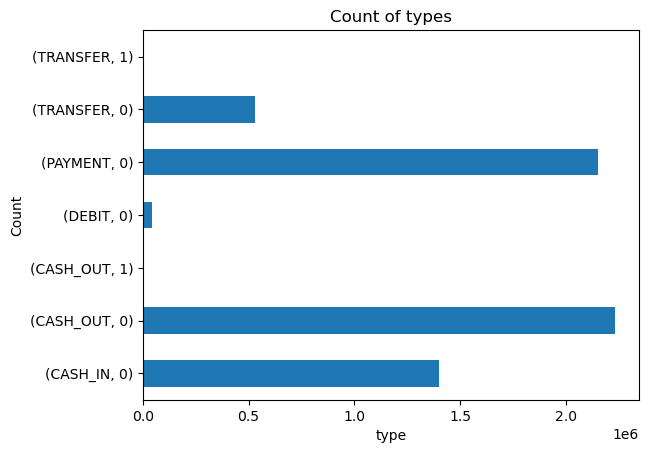

In [12]:
financials.groupby('type')['isFraud'].value_counts().plot(kind='barh')
plt.xlabel('type')
plt.ylabel('Count')
plt.title('Count of types')
plt.show()

This chart grouped the data by type than gave me the value counts of the 'isFraud' column. All types had 0, or nonfraudulent transactions. However, only CASH_OUT & TRANSFER columns had 1's, or fraudulent transactions. What this means is we can filter out data from the columns that do not have fraud in them. This makes the dataset more managable and prevents the data from other trasation types from creating noise.

In [13]:
#creating a dataframe of the CASH_OUT and TRANFER types, encompassing all of our fraud data
tiny_financials = financials[(financials['type'] == 'CASH_OUT') | (financials['type'] == 'TRANSFER')]
tiny_financials.head(10)

,type,Amount,nameOrig,OldOrig,NewOrig,nameDest,OldDest,NewDest,isFraud,isFlaggedFraud
step,,,,,,,,,,
1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0
1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0
1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0
1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0
1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0


In [14]:
#seperate numerical columns
numerical_columns = ['Amount','OldOrig','NewOrig','OldDest', 'NewDest']
# create a standard scaler object
scaler = StandardScaler()
# Scale the numerical columns
scaled_values = scaler.fit_transform(tiny_financials[numerical_columns])
scaled_financials = pd.DataFrame(scaled_values, columns=(numerical_columns))
#put the isFraud column back to visualize fraud across distributions
scaled_financials = scaled_financials.merge(tiny_financials['isFraud'], how='left', on=scaled_financials.index, right_index=False)
scaled_financials.head()

,key_0,Amount,OldOrig,NewOrig,OldDest,NewDest,isFraud
0,0,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259,1
1,1,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259,1
2,2,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245,0
3,3,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259,0
4,4,-0.006590,-0.146456,-0.106389,-0.401672,0.143134,0


Had to merge the isFraud column back on after the normalization. I could likely adjust code so the key_0 column doesn't appear, however it is just as easily dropped when we clean the data.

In [15]:
#we should do the same for the fraud and non fraud datasets as well
scaled_f_values = scaler.fit_transform(fraud[numerical_columns])
scaled_fraud = pd.DataFrame(scaled_f_values, columns=(numerical_columns))
scaled_nf_values = scaler.fit_transform(not_fraud[numerical_columns])
scaled_notfraud = pd.DataFrame(scaled_nf_values, columns=(numerical_columns))
scaled_fraud.head()

,Amount,OldOrig,NewOrig,OldDest,NewDest
0,-0.610533,-0.464971,-0.097882,-0.163134,-0.32741
1,-0.610533,-0.464971,-0.097882,-0.156785,-0.32741
2,-0.609441,-0.464231,-0.097882,-0.163134,-0.32741
3,-0.609441,-0.464231,-0.097882,-0.155280,-0.32741
4,-0.602236,-0.459348,-0.097882,-0.163134,-0.32741


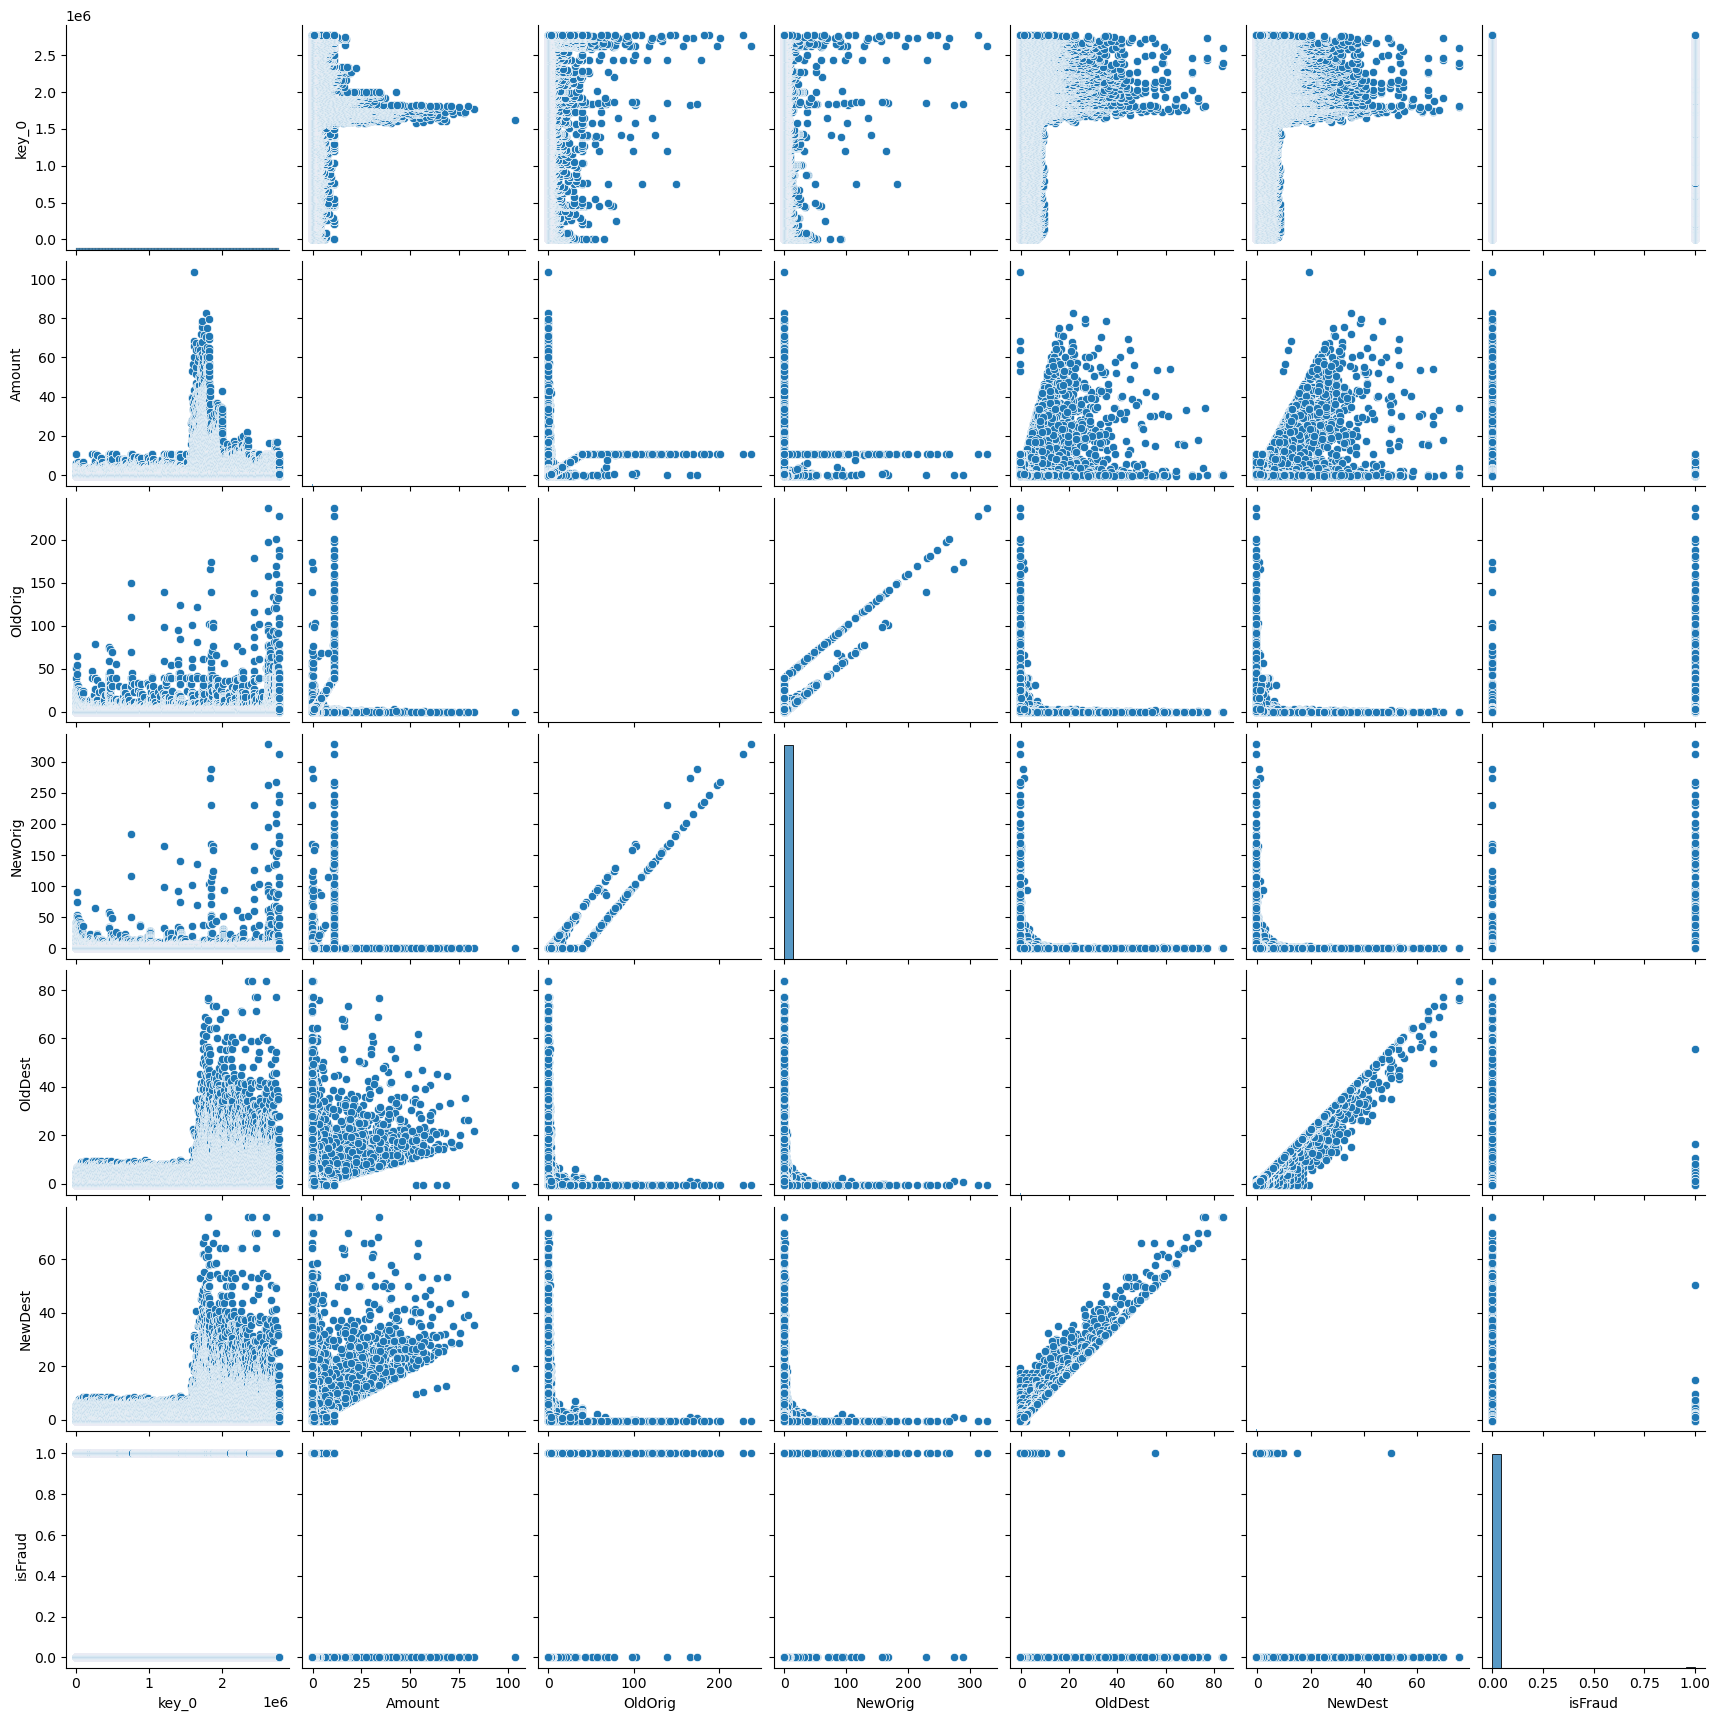

In [ ]:
sns.pairplot(scaled_financials)
plt.show()

This visulaisation shows us the bivariate distibution of numerical columns in the type-filtered dataset. It's hard to come to any conclusions, but it allows us to see the natural disributions of the data.

Continuing the bivariate analysis,I am going to create a heatmap to see correlation between the numerical features. I will also creat a second heatmap showing correlation between features in the fraudulent dataset.

<Axes: >

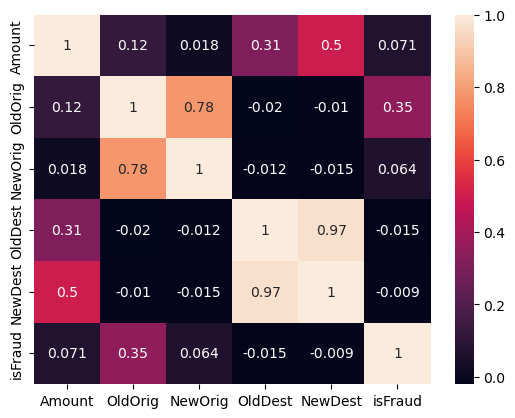

In [16]:
scaled_financials = scaled_financials.drop(columns='key_0')
#we want to find correlation between the values in fraud so i will create a heatmap
sns.heatmap(scaled_financials.corr(),annot=True)

When trying to decipher this chart, it is important to keep in mind that the data is baning. Therefore, it makes a ton of sense that the Old Balance and New Balance of both Original and Destination accounts have strong positive correlation. After all, most people's transactions are tiny and balances will remain similar regardless of what occurs. 

When it comes to Fraud, it seems both destination features have high coorelation. This is something I would like to look at further. Having made a seperate dataset for fraudulent data, we

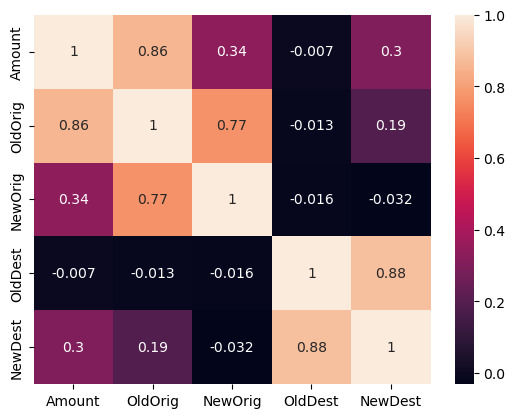

In [22]:
sns.heatmap(scaled_fraud.corr(), annot=True)
plt.show()

The Fraud dataset shows shows key differences in the Amount column.

##### It is very likely that our Amount feature will be included in our best performing model



Comparisons amongst all 4 pairs of balance features against the amount feature. I will also create 1 plot showing the distribution of the Fraudulent dataset and 1 plot showing the non fraudulent dataset. The hope is this will help me identify what trends we saw in the heatmap.

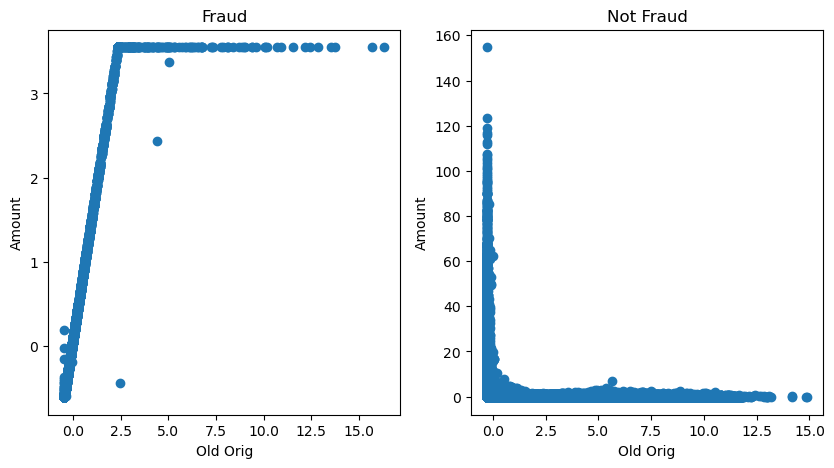

In [ ]:
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.subplot(1, 2, 1)  # First subplot (2 row, 2 columns, 1st position)
plt.scatter(scaled_fraud['OldOrig'], scaled_fraud['Amount'])
plt.xlabel('Old Orig')
plt.ylabel('Amount')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
plt.scatter(scaled_notfraud['OldOrig'], scaled_notfraud['Amount'])
plt.xlabel('Old Orig')
plt.ylabel('Amount')
plt.title('Not Fraud')
plt.show()

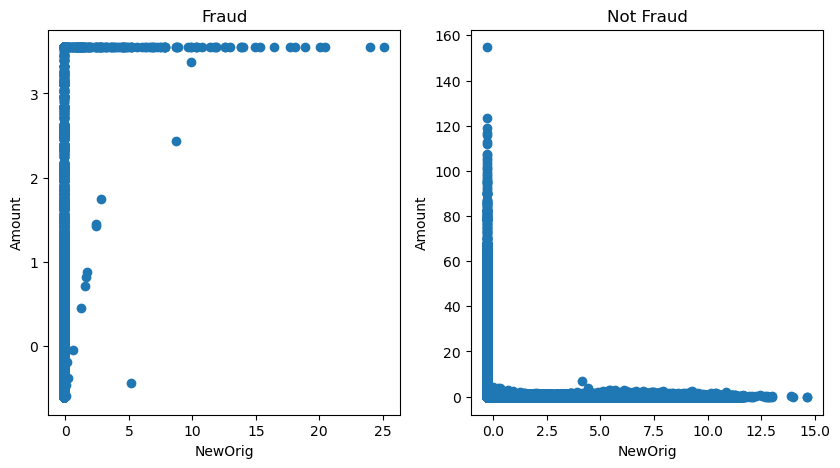

In [ ]:
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.subplot(1, 2, 1)  # First subplot (2 row, 2 columns, 1st position)
plt.scatter(scaled_fraud['NewOrig'], scaled_fraud['Amount'])
plt.xlabel('NewOrig')
plt.ylabel('Amount')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (2 row, 2 columns, 2nd position)
plt.scatter(scaled_notfraud['NewOrig'], scaled_notfraud['Amount'])
plt.xlabel('NewOrig')
plt.ylabel('Amount')
plt.title('Not Fraud')
plt.show()

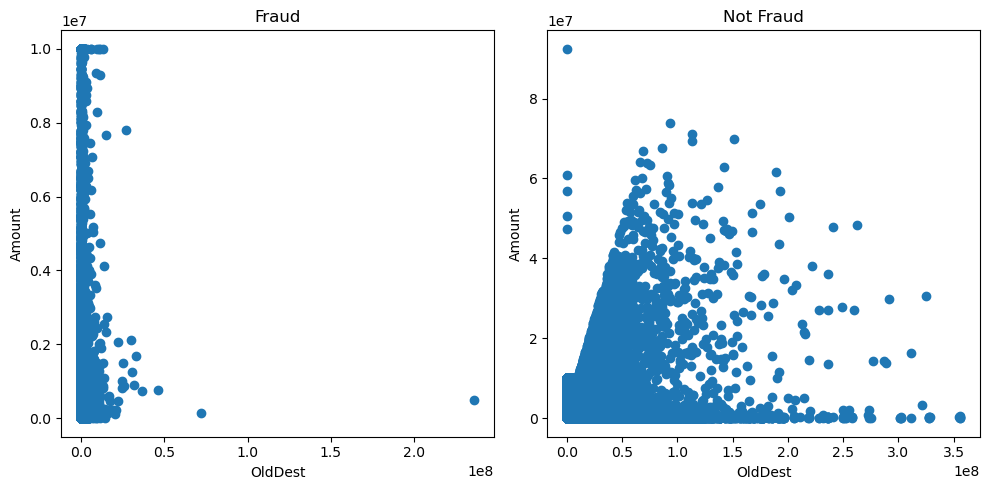

In [ ]:
plt.figure(figsize=(10, 5))# Adjust figure size as needed
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st position)
plt.scatter(scaled_fraud['OldDest'], scaled_fraud['Amount'])
plt.xlabel('OldDest')
plt.ylabel('Amount')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
plt.scatter(scaled_notfraud['OldDest'], scaled_notfraud['Amount'])
plt.xlabel('OldDest')
plt.ylabel('Amount')
plt.title('Not Fraud')
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

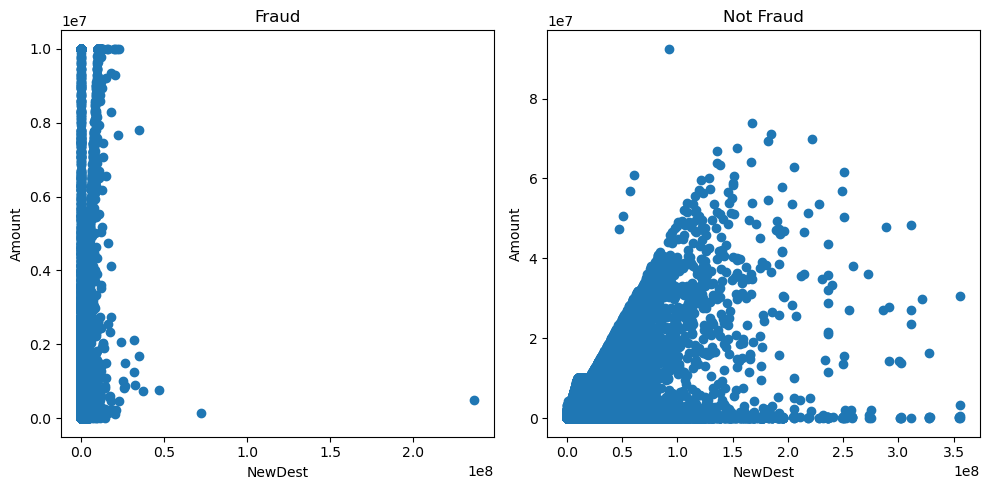

In [ ]:
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st position)
plt.scatter(fraud['NewDest'], fraud['Amount'])
plt.xlabel('NewDest')
plt.ylabel('Amount')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
plt.scatter(not_fraud['NewDest'], not_fraud['Amount'])
plt.xlabel('NewDest')
plt.ylabel('Amount')
plt.title('Not Fraud')
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

In [ ]:
x = not_fraud[not_fraud['NewDest'] != 0]
x.count()

type              3919065
Amount            3919065
nameOrig          3919065
OldOrig           3919065
NewOrig           3919065
nameDest          3919065
OldDest           3919065
NewDest           3919065
isFraud           3919065
isFlaggedFraud    3919065
dtype: int64

The Old Dest and New Dest balances charts largely look identical in both datasets. HOWEVER, THE OUTLIERS ARE IDENTICAL IN FRAUD CASES. This is not reflected in the not fraud column. 
##### It would seem that a lack of change between the destination accounts may be a distinguishing factor of Fraud

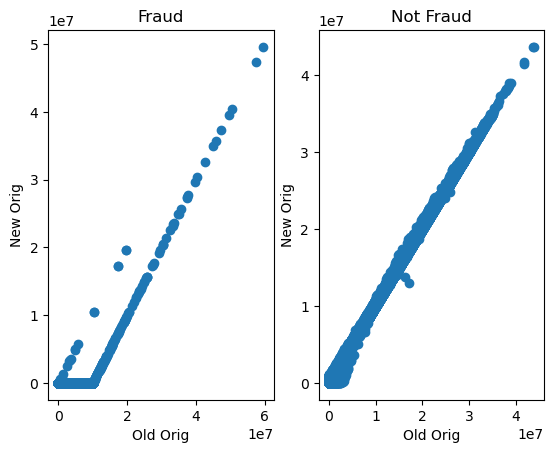

In [ ]:
plt.figure(figsize=(10, 5))# Adjust figure size as needed
plt.subplot(1, 2, 1)  # First subplot (2 row, 2 columns, 1st position)
plt.scatter(scaled_fraud['OldOrig'], scaled_fraud['NewOrig'])
plt.xlabel('Old Orig')
plt.ylabel('New Orig')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
plt.scatter(scaled_notfraud['OldOrig'], scaled_notfraud['NewOrig'])
plt.xlabel('Old Orig')
plt.ylabel('New Orig')
plt.title('Not Fraud')
plt.show()

The distribution of values has a very linear relationship. This makes sense when considering these are monetary transactions. Depending on the transaction type, money will be added or subtracted from the original account and then be reflected in the new account. In my multivariate analysis, I would like to visualize how the types of transactions are distributed here.

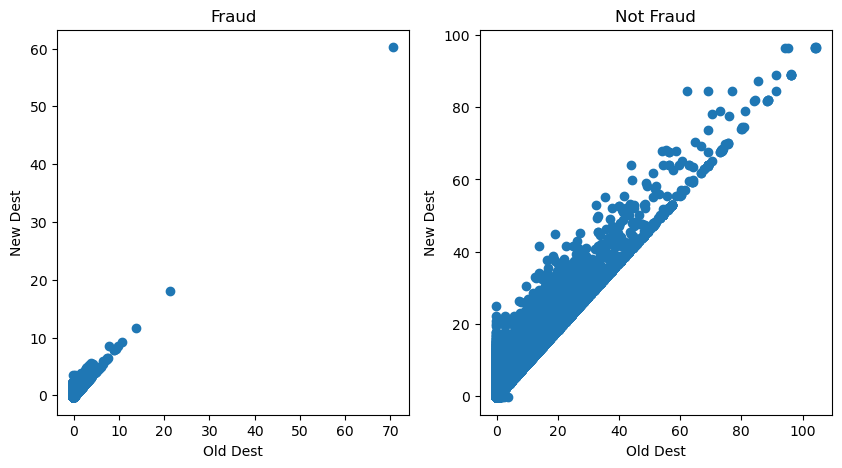

In [38]:
plt.figure(figsize=(10, 5))# Adjust figure size as needed
plt.tight_layout()
plt.subplot(1, 2, 1)  # First subplot (2 row, 2 columns, 1st position)
plt.scatter(scaled_fraud['OldDest'], scaled_fraud['NewDest'])
plt.xlabel('Old Dest')
plt.ylabel('New Dest')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
plt.scatter(scaled_notfraud['OldDest'], scaled_notfraud['NewDest'])
plt.xlabel('Old Dest')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('New Dest')
plt.title('Not Fraud')
plt.show()

This seems to start following a normal distribution and than abruptly stops in the fraudulent data. For some reason, the middle portion of the data does not exist in the fraudulent dataset. Is this because of a concentration of lower values? 

##### I believe I might be able to make a regression model out of this. That will be my baseline model.

## Multivariate Analysis

My first step for multivariate variate analysis is to create a pairplot with colors differentiating fraudulent and non-fraudulent data. 

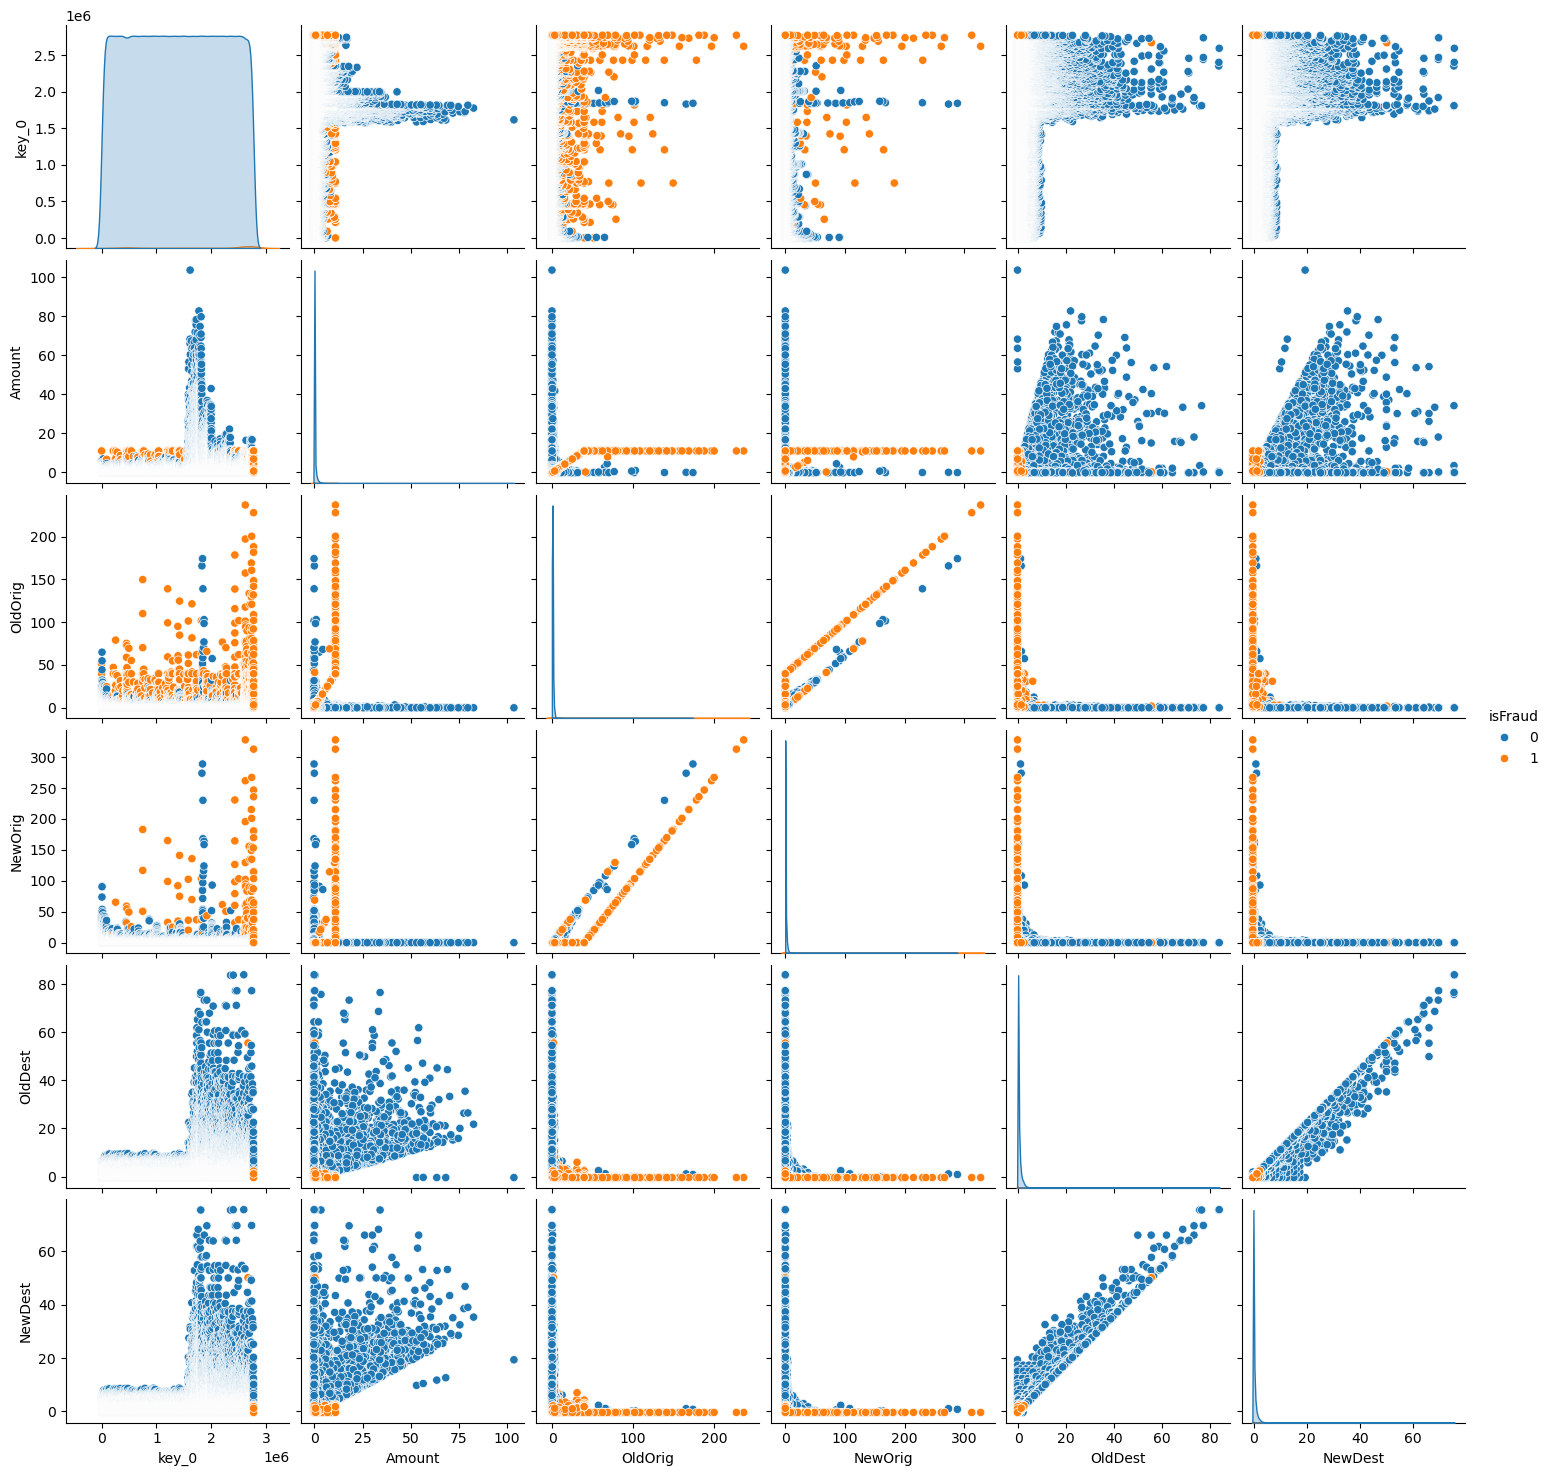

In [ ]:
sns.pairplot(scaled_financials, hue='isFraud')
plt.legend(['Not Fraud', 'Fraud'])
plt.show()

We can see o

In [27]:
type_financials = scaled_financials.merge(tiny_financials['type'], on=scaled_financials.index, how='left')
type_financials = type_financials.drop(columns='key_0')
type_financials['type'] = type_financials['type'].map({'TRANSFER':1,'CASH_OUT':2})
type_financials


,Amount,OldOrig,NewOrig,OldDest,NewDest,isFraud,type
0,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259,1,1
1,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259,1,2
2,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245,0,2
3,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259,0,1
4,-0.006590,-0.146456,-0.106389,-0.401672,0.143134,0,1
...,...,...,...,...,...,...,...
2770404,0.024945,1.161997,-0.106389,-0.403155,-0.365631,1,2
2770405,6.751458,24.922965,-0.106389,-0.403155,-0.438259,1,1
2770406,6.751458,24.922965,-0.106389,-0.386947,0.925844,1,2
2770407,0.599766,3.192516,-0.106389,-0.403155,-0.438259,1,1


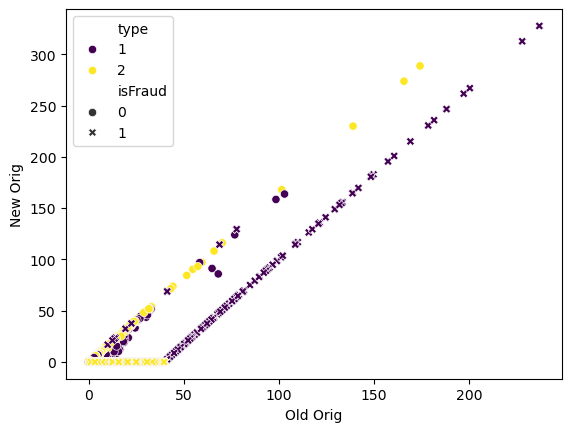

In [47]:
sns.scatterplot(data=type_financials, x='OldOrig', y='NewOrig', hue='type', style='isFraud', palette='viridis')
plt.xlabel('Old Orig')
plt.ylabel('New Orig')
plt.show()

In [35]:
fraud_transfers = type_financials[(type_financials['type'] == 1) & (type_financials['isFraud'] == 1)]
not_fraud_transfers = type_financials[(type_financials['type'] == 1) & (type_financials['isFraud'] == 0)]
fraud_cash_outs = type_financials[(type_financials['type'] == 2) & (type_financials['isFraud'] == 1)]
not_fraud_cash_outs = type_financials[(type_financials['type'] == 2) & (type_financials['isFraud'] == 0)]


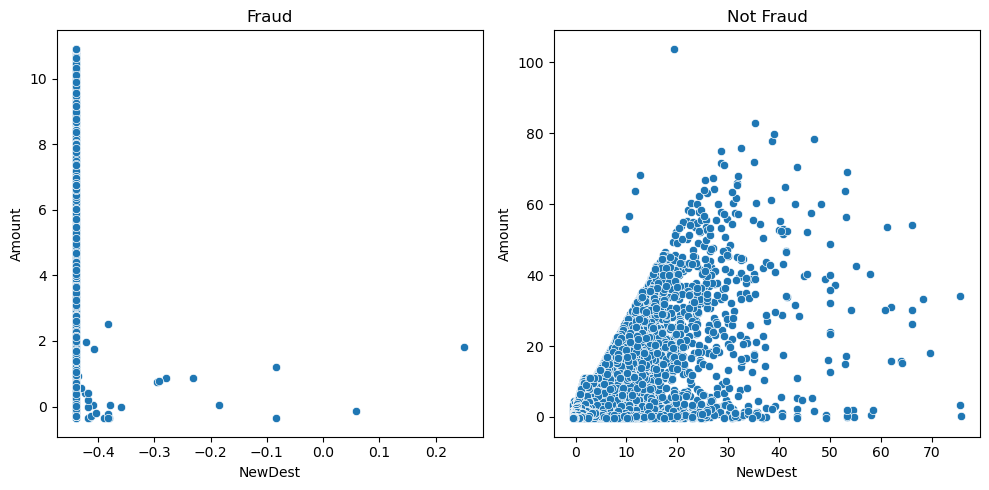

In [39]:
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st position)
sns.scatterplot(data = fraud_transfers, x = fraud_transfers['NewDest'], y = fraud_transfers['Amount'])
plt.xlabel('NewDest')
plt.ylabel('Amount')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
sns.scatterplot(data = not_fraud_transfers, x = not_fraud_transfers['NewDest'], y = not_fraud_transfers['Amount'])
plt.xlabel('NewDest')
plt.ylabel('Amount')
plt.title('Not Fraud')
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

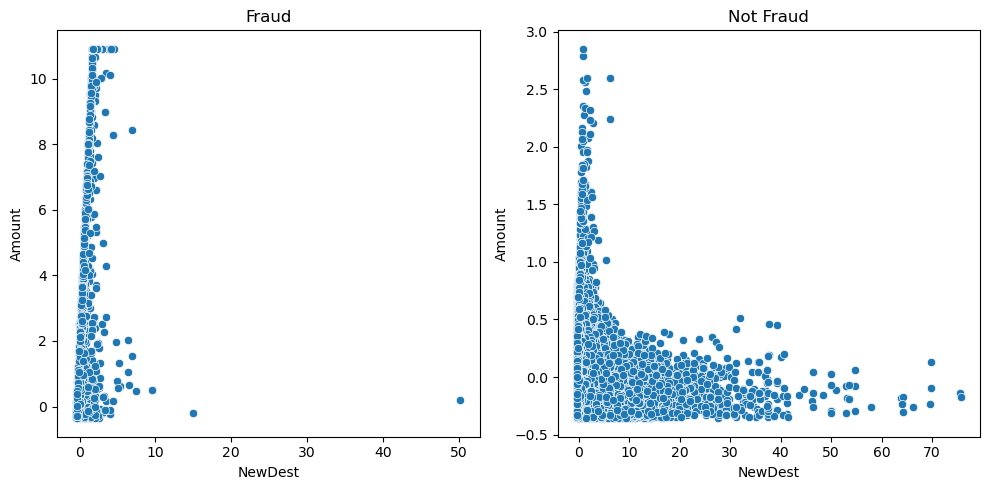

In [40]:
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st position)
sns.scatterplot(data = fraud_cash_outs, x = fraud_cash_outs['NewDest'], y = fraud_cash_outs['Amount'])
plt.xlabel('NewDest')
plt.ylabel('Amount')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
sns.scatterplot(data = not_fraud_cash_outs, x = not_fraud_cash_outs['NewDest'], y = not_fraud_cash_outs['Amount'])
plt.xlabel('NewDest')
plt.ylabel('Amount')
plt.title('Not Fraud')
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

In [42]:
fraud_transfers.count()

Amount     4097
OldOrig    4097
NewOrig    4097
OldDest    4097
NewDest    4097
isFraud    4097
type       4097
dtype: int64

In [ ]:
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st position)
sns.scatterplot(data = transfers, x = transfers['OldDest'], y = transfers['NewDest'], hue=transfers['isFraud'])
plt.xlabel('OldDest')
plt.ylabel('NewDest')
plt.title('Fraud')
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, 2nd position)
sns.scatterplot(data = cash_outs, x = cash_outs['OldDest'], y = cash_outs['NewDest'], hue=cash_outs['isFraud'])
plt.xlabel('OldDest')
plt.ylabel('NewDest')
plt.title('Not Fraud')
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

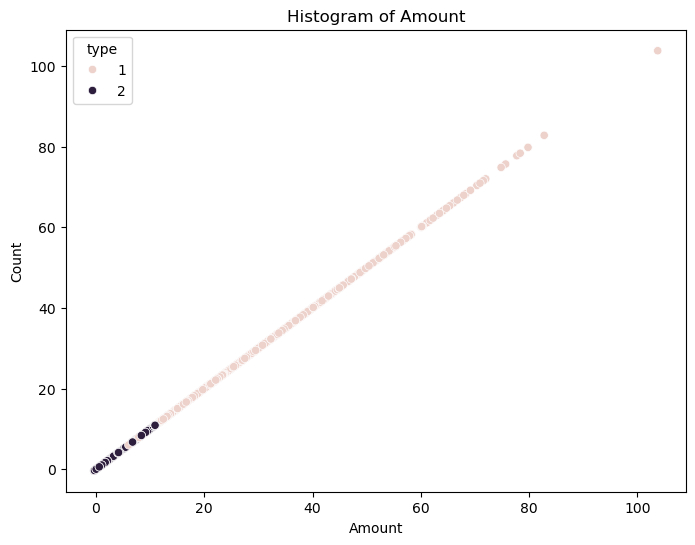

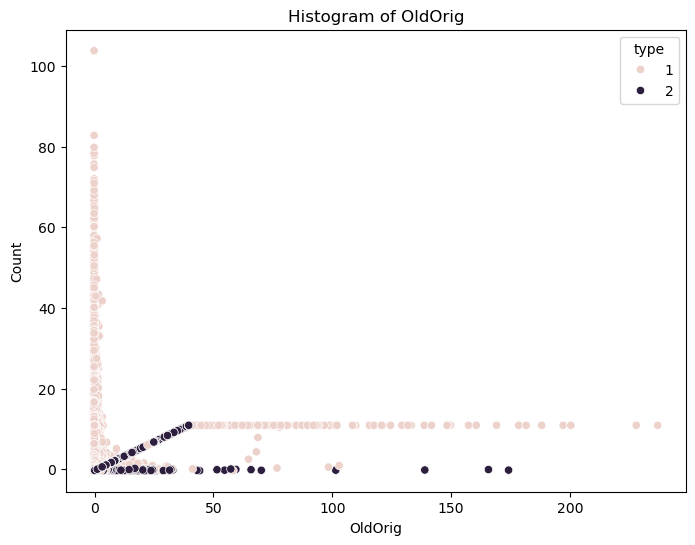

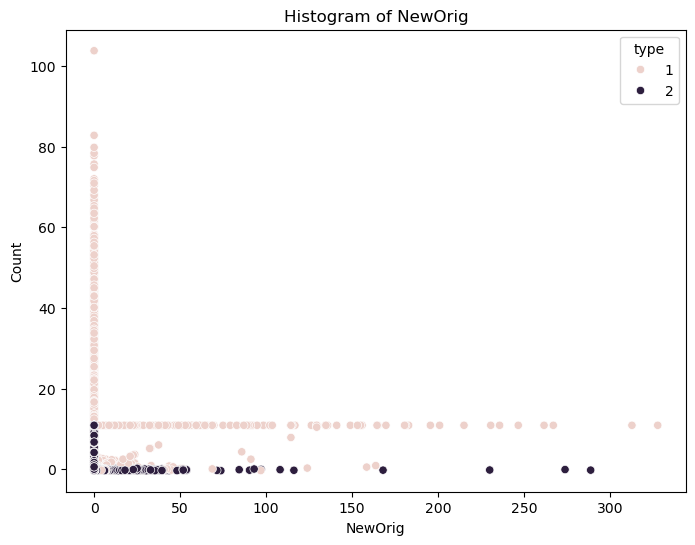

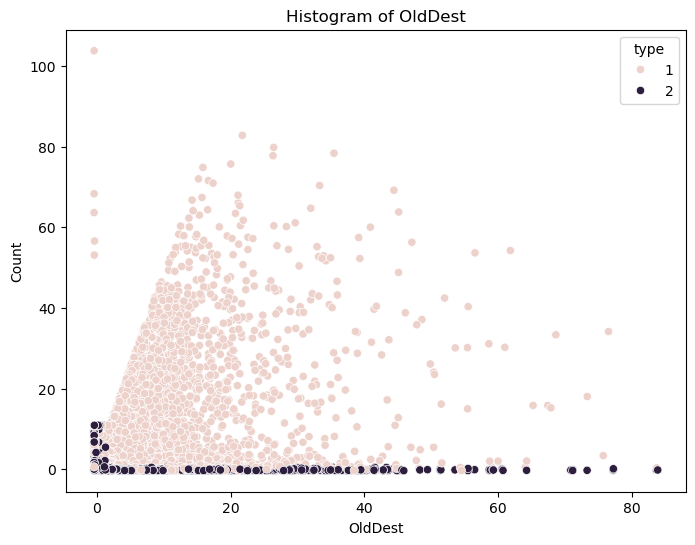

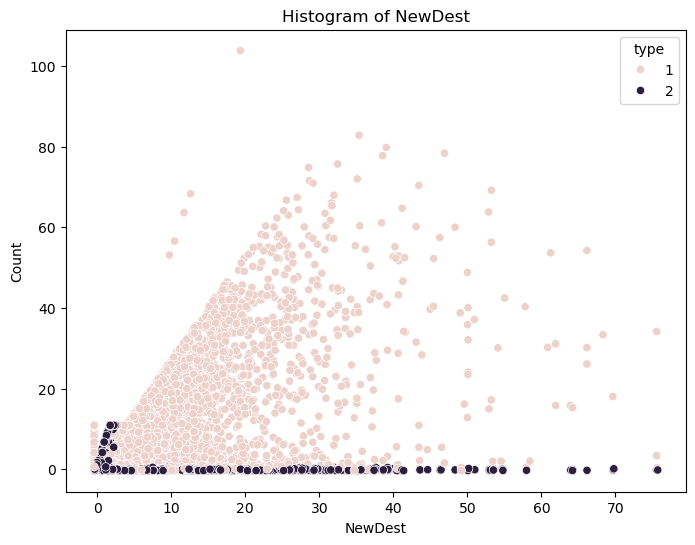

In [29]:
for feature in plot_fraud:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=type_financials, x=feature, y=type_financials['Amount'], hue = type_financials['type'] )
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Histogram of {feature}')
    plt.show()


# Final Conclusions

This large dataset proved to be difficult to 